In [11]:
import pandas as pd
from rdkit import Chem
import pickle
import matplotlib.pyplot as plt

import sys
sys.path.append('../')

import ml
import utils
from analysis import CV, Predictions

import numpy as np
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
pd.set_option("display.precision", 4)

In [12]:
def plot_comparison(data_dict,sel_metric):
    comparison_df = pd.DataFrame(data_dict)
    sns.violinplot(comparison_df)
    # rotate xlabels
    plt.xticks(rotation=75)

    if sel_metric == "MCC":
        plt.ylim(-0.1, 1.)
        plt.axhline(0., color='k', linestyle='--')
        plt.ylabel(f"Matthews Correlation Coefficient (MCC)")
    elif sel_metric == "balanced accuracy":
        plt.ylim(0.19, 1.01)
        plt.axhline(0.5, color='k', linestyle='--')
        plt.ylabel(f"Balanced Accuracy")
    elif sel_metric == "NPV":
        plt.ylim(0.9, 1.0)
        plt.ylabel(f"Negative Predictive Value (NPV)")
    elif sel_metric == "PPV":
        plt.ylabel(f"Positive Predictive Value (PPV)")
    elif sel_metric == "TPR":
        plt.ylabel(f"True Positive Rate (TPR)")
    elif sel_metric == "TNR":
        plt.ylim(0.4, 1.0)
        plt.ylabel(f"True Negative Rate (TNR)")
    return comparison_df

In [3]:
# calculate "classic" metrics via sckit-learn scores
def calc_metrics(splits,sel_metric):
    metrics = []
    for split in splits:
        y = split["y"]
        y_pred = split["y_hat"]
        metric = 0
        if sel_metric == "balanced accuracy":
            metric = balanced_accuracy_score(y, y_pred)
            #print(metric)
        elif sel_metric == "MCC":
            metric = matthews_corrcoef(y, y_pred)
        elif sel_metric == "recall":
            metric = recall_score(y, y_pred)
        elif sel_metric == "precision":
            metric = precision_score(y, y_pred)
        elif sel_metric == "TNR":
            metric = recall_score(y, y_pred, pos_label=0)
        elif sel_metric == "NPV":
            metric = precision_score(y, y_pred, pos_label="inactive")
        metrics.append(metric)

    return metrics

In [42]:
# calculate metrics and associated uncertainty estimates via Bayesian inference (here "positive" label needs to be "inhibitor")
from sklearn.metrics import confusion_matrix
def calc_metrics_Bayesian(splits,sel_metric):
    metrics = []
    
    sample_size_posterior = 10000
    prior = 1
    label_threshold = 0.5
    
    for fold in splits.folds:
        curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold)
        #curr_cm = confusion_matrix(fold.y == "inhibitor", fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        #metrics.append(curr_samples)
        metrics += list(curr_samples)

    return metrics

In [40]:
# calculate metrics and associated uncertainty estimates via Bayesian inference (here "positive" label needs to be 1)
from sklearn.metrics import confusion_matrix
def calc_metrics_Bayesian_binary_class(splits,sel_metric):
    metrics = []
    
    sample_size_posterior = 10000
    prior = 1
    label_threshold = 0.5
    
    for fold in splits.folds:
        curr_cm = confusion_matrix(fold.y == 1, fold.y_hat_proba[:, 1] >= label_threshold, labels=[True, False])
        TP, FN, FP, TN = curr_cm.flatten()
        tpr_samples = np.random.beta(TP + prior, FN + prior, size=sample_size_posterior)
        tnr_samples = np.random.beta(TN + prior, FP + prior, size=sample_size_posterior)
        ppv_samples = np.random.beta(TP + prior, FP + prior, size=sample_size_posterior)
        npv_samples = np.random.beta(TN + prior, FN + prior, size=sample_size_posterior)
        if sel_metric == "balanced accuracy":
            curr_samples = (tpr_samples + tnr_samples) / 2
        elif sel_metric == "MCC":
            curr_samples = np.sqrt(tpr_samples * tnr_samples * ppv_samples * npv_samples) - np.sqrt(
                (1 - tpr_samples) * (1 - tnr_samples) * (1 - ppv_samples) * (1 - npv_samples))
        elif sel_metric == "NPV":
            curr_samples = npv_samples
        elif sel_metric == "TNR":
            curr_samples = tnr_samples
        elif sel_metric == "TPR":
            curr_samples = tpr_samples
        elif sel_metric == "PPV":
            curr_samples = ppv_samples
        #metrics.append(curr_samples)
        metrics += list(curr_samples)

    return metrics

In [43]:
sel_metric = "balanced accuracy"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_BA = pd.DataFrame(columns=['model', 'mean_BA', 'std_BA'])
df_BA_full={}
for model in models:
    results_file = f"splits_unrestricted_new_desc_fps_scaled_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian(CV_unrestricted,"balanced accuracy"))
    
    if model == 'xgb':
        df=pd.DataFrame(calc_metrics_Bayesian_binary_class(CV_unrestricted,"balanced accuracy"))     
    
    mean = df.mean()[0]
    std=df.std()[0]
    df_BA.loc[len(df_BA)] = [model, mean,std]
    
    df_BA_full[model]=df.iloc[:,0].values
    
print(df_BA.to_string(index=False))

   model  mean_BA  std_BA
     gbt   0.8170  0.0133
catboost   0.8177  0.0148
      lr   0.7890  0.0173
      rf   0.6706  0.0160
     svm   0.7316  0.0204
     xgb   0.7338  0.0184


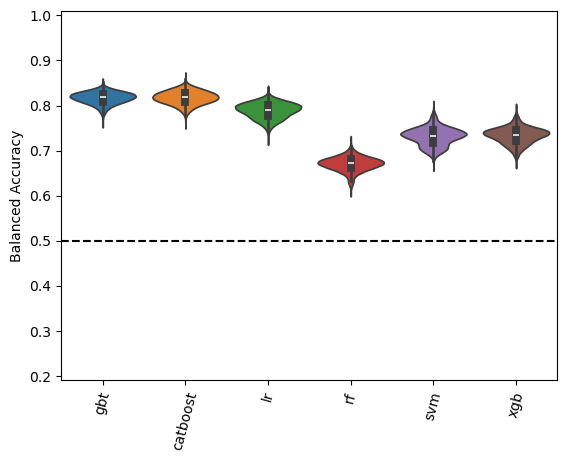

In [31]:
comparison_df_BA_Bayesian=plot_comparison(df_BA_full, "balanced accuracy")

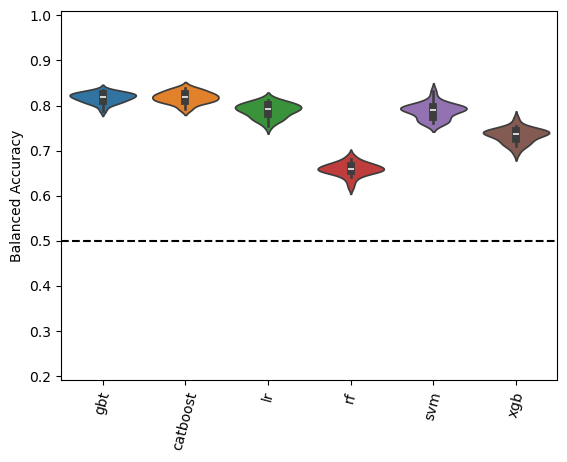

In [18]:
sel_metric = "balanced accuracy"
data_dict_BA = {}
#models = ['gbt','catboost','lr','rf','svm','xgb']
models = ['gbt','catboost','lr','rf','svm','xgb']
for model in models:
    #print(model)
    results_file = f"splits_unrestricted_new_desc_fps_scaled_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    metrics = calc_metrics(splits,sel_metric)
    data_dict_BA[model] = metrics
comparison_df_BA=plot_comparison(data_dict_BA, "balanced accuracy")

In [35]:
data_dict_BA

{'gbt': [0.8343529584501197,
  0.8061256413465148,
  0.8293261947724182,
  0.8081261252480767,
  0.8253968609102966,
  0.7986941286234266,
  0.8146100591254882,
  0.8236507714902579,
  0.8203988781087654,
  0.822262831908265,
  0.81869614516896,
  0.8248395476296426,
  0.8274693756569476,
  0.8040235123842991,
  0.8150842420630446,
  0.8100915756541793,
  0.8253844257952726,
  0.8246504440878847,
  0.8154521999990092,
  0.8167683827802035,
  0.8308466225852458,
  0.8299692650300105,
  0.7884431050641502,
  0.806938885952327,
  0.8164444681344729],
 'catboost': [0.8221391044742405,
  0.816833710651756,
  0.8232415155897633,
  0.808837555144519,
  0.8317794200911526,
  0.7922878112812495,
  0.822007441824221,
  0.8355720163839995,
  0.8080357626531022,
  0.8270849490967109,
  0.8236804608248176,
  0.8121602579204077,
  0.8371893976755886,
  0.8046917870565271,
  0.8146889379271836,
  0.8103092612983871,
  0.8122526915869994,
  0.8264242309609642,
  0.821835937693531,
  0.8198950741287998

In [48]:
sel_metric = "MCC"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_MCC = pd.DataFrame(columns=['model', 'mean_MCC', 'std_MCC'])
df_MCC_full={}
for model in models:
    results_file = f"splits_unrestricted_new_desc_fps_scaled_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian(CV_unrestricted,"MCC"))
    
    if model == 'xgb':
        df=pd.DataFrame(calc_metrics_Bayesian_binary_class(CV_unrestricted,"MCC"))     
    
    mean = df.mean()[0]
    std=df.std()[0]
    df_MCC.loc[len(df_MCC)] = [model, mean,std]
    
    df_MCC_full[model]=df.iloc[:,0].values
    
print(df_MCC.to_string(index=False))

   model  mean_MCC  std_MCC
     gbt    0.5130   0.0231
catboost    0.5684   0.0263
      lr    0.4831   0.0280
      rf    0.4921   0.0297
     svm    0.5495   0.0327
     xgb    0.5573   0.0297


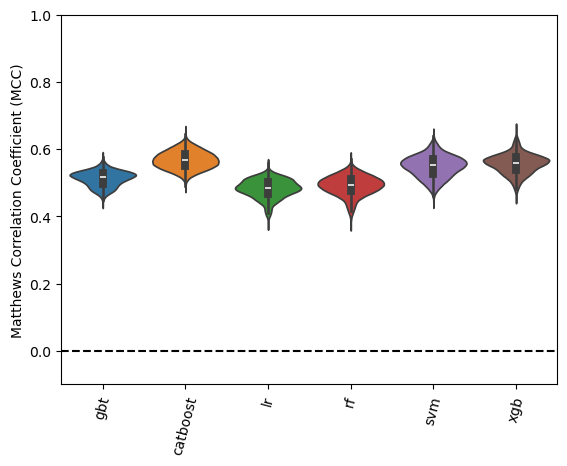

In [49]:
comparison_df_MCC_Bayesian=plot_comparison(df_MCC_full, "MCC")

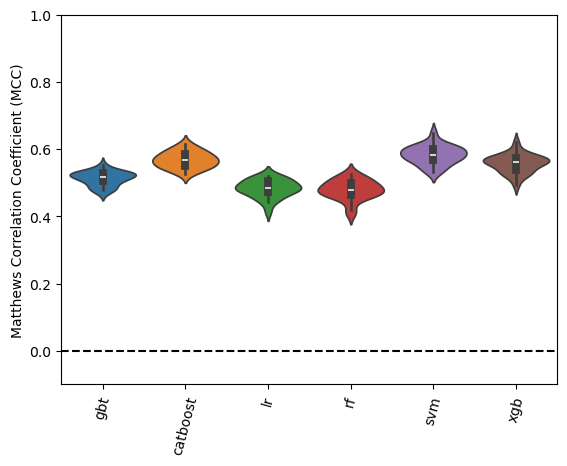

In [50]:
sel_metric = "MCC"
data_dict_MCC = {}
#models = ['gbt','catboost','lr','rf','svm','xgb']
models = ['gbt','catboost','lr','rf','svm','xgb']
for model in models:
    #print(model)
    results_file = f"splits_unrestricted_new_desc_fps_scaled_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    metrics = calc_metrics(splits,sel_metric)
    data_dict_MCC[model] = metrics
comparison_df_MCC=plot_comparison(data_dict_MCC, "MCC")

In [32]:
results_file = f"splits_unrestricted_new_desc_fps_scaled_svm_HPC.pkl"
splits = pd.read_pickle(results_file)

In [33]:
splits

[{'y': 0         inactive
  8         inactive
  15        inactive
  16        inactive
  24       inhibitor
             ...    
  24928    inhibitor
  24933     inactive
  24935     inactive
  24949    inhibitor
  24950    inhibitor
  Name: final class, Length: 4945, dtype: object,
  'y_hat': array(['inactive', 'inactive', 'inactive', ..., 'inactive', 'inhibitor',
         'inactive'], shape=(4945,), dtype=object),
  'y_hat_proba': array([[0.94942542, 0.05057458],
         [0.95087116, 0.04912884],
         [0.94559316, 0.05440684],
         ...,
         [0.99824048, 0.00175952],
         [0.38055348, 0.61944652],
         [0.75092684, 0.24907316]], shape=(4945, 2)),
  'val_index': array([    0,     8,    15, ..., 24935, 24949, 24950], shape=(4945,))},
 {'y': 4         inactive
  6         inactive
  12        inactive
  20       inhibitor
  21        inactive
             ...    
  24940     inactive
  24941     inactive
  24943    inhibitor
  24948    inhibitor
  24951     inacti

In [34]:
results_file = f"splits_unrestricted_new_desc_fps_scaled_xgb_HPC.pkl"
splits_xgb = pd.read_pickle(results_file)
splits_xgb

[{'y': 0        0
  8        0
  15       0
  16       0
  24       1
          ..
  24928    1
  24933    0
  24935    0
  24949    1
  24950    1
  Name: final class, Length: 4945, dtype: int64,
  'y_hat': array([0, 0, 0, ..., 0, 1, 0], shape=(4945,)),
  'y_hat_proba': array([[9.9631917e-01, 3.6808148e-03],
         [9.9750370e-01, 2.4962837e-03],
         [9.9121273e-01, 8.7872455e-03],
         ...,
         [9.9970633e-01, 2.9364650e-04],
         [2.9294842e-01, 7.0705158e-01],
         [5.2250212e-01, 4.7749788e-01]], shape=(4945, 2), dtype=float32),
  'val_index': array([    0,     8,    15, ..., 24935, 24949, 24950], shape=(4945,))},
 {'y': 4        0
  6        0
  12       0
  20       1
  21       0
          ..
  24940    0
  24941    0
  24943    1
  24948    1
  24951    0
  Name: final class, Length: 5055, dtype: int64,
  'y_hat': array([0, 1, 0, ..., 0, 0, 1], shape=(5055,)),
  'y_hat_proba': array([[0.99311805, 0.00688192],
         [0.32086444, 0.67913556],
         

In [91]:
sel_metric = "balanced accuracy"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_BA_full = pd.DataFrame(columns=['model', 'mean_BA', 'std_BA'])
for model in models:
    results_file = f"splits_full_HTS_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian_binary_class(CV_unrestricted,"balanced accuracy"))
    mean = df.mean()[0]
    std=df.std()[0]
    df_BA_full.loc[len(df_BA_full)] = [model, mean,std]
print(df_BA_full.to_string(index=False))

   model  mean_BA  std_BA
     gbt   0.7717  0.0134
catboost   0.7356  0.0157
      lr   0.5437  0.0867
      rf   0.5446  0.0107
     svm   0.5005  0.0007
     xgb   0.5803  0.0144


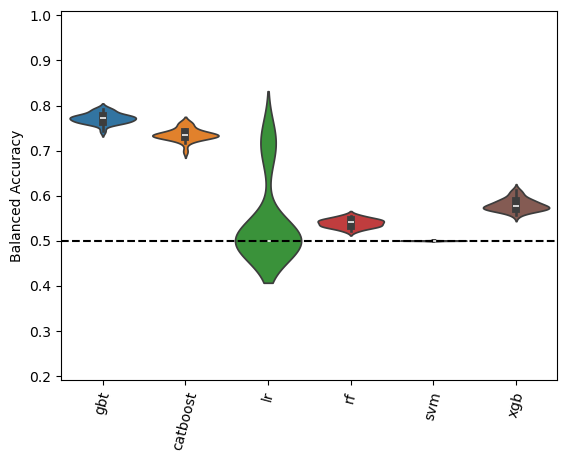

In [92]:
sel_metric = "balanced accuracy"
data_dict_BA_full = {}
models = ['gbt','catboost','lr','rf','svm','xgb']
for model in models:
    #print(model)
    results_file = f"splits_full_HTS_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    metrics = calc_metrics(splits,sel_metric)
    data_dict_BA_full[model] = metrics
comparison_df_BA_full=plot_comparison(data_dict_BA_full, "balanced accuracy")

In [93]:
sel_metric = "MCC"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_MCC_full = pd.DataFrame(columns=['model', 'mean_MCC', 'std_MCC'])
for model in models:
    results_file = f"splits_full_HTS_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian_binary_class(CV_unrestricted,sel_metric))
    mean = df.mean()[0]
    std=df.std()[0]
    df_MCC_full.loc[len(df_MCC_full)] = [model, mean,std]
print(df_MCC_full.to_string(index=False))

   model  mean_BA  std_BA
     gbt   0.2900  0.0173
catboost   0.3298  0.0238
      lr   0.0572  0.0799
      rf   0.2470  0.0360
     svm   0.0162  0.0138
     xgb   0.2951  0.0342


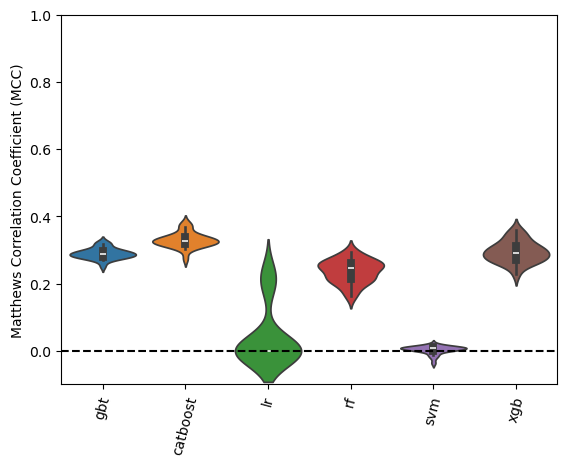

In [95]:
sel_metric = "MCC"
data_dict_MCC_full = {}
models = ['gbt','catboost','lr','rf','svm','xgb']
for model in models:
    #print(model)
    results_file = f"splits_full_HTS_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    metrics = calc_metrics(splits,sel_metric)
    data_dict_MCC_full[model] = metrics
comparison_df_MCC_full=plot_comparison(data_dict_MCC_full, "MCC")

In [42]:
sel_metric = "MCC"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_MCC = pd.DataFrame(columns=['model', 'mean_MCC', 'std_MCC'])
for model in models:
    print(model)
    results_file = f"splits_unrestricted_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian(CV_unrestricted,sel_metric))
    mean = df.mean()[0]
    std=df.std()[0]
    df_MCC.loc[len(df_MCC)] = [model, mean,std]
print(df_MCC.to_string(index=False))

gbt
catboost
lr
rf
svm
xgb
   model  mean_MCC  std_MCC
     gbt    0.5131   0.0230
catboost    0.5647   0.0273
      lr    0.0760   0.1344
      rf    0.4934   0.0320
     svm    0.0162   0.0138
     xgb    0.0223   0.0172


In [44]:
sel_metric = "TNR"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_TNR = pd.DataFrame(columns=['model', 'mean_specificity', 'std_specificity'])
for model in models:
    results_file = f"splits_unrestricted_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian(CV_unrestricted,sel_metric))
    mean = df.mean()[0]
    std=df.std()[0]
    df_TNR.loc[len(df_TNR)] = [model, mean,std]
print(df_TNR.to_string(index=False))

   model  mean_specificity  std_specificity
     gbt            0.8257           0.0138
catboost            0.8934           0.0097
      lr            0.7800           0.3601
      rf            0.9859           0.0025
     svm            0.9998           0.0002
     xgb            0.8998           0.0099


In [96]:
sel_metric = "TNR"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_TNR_full = pd.DataFrame(columns=['model', 'mean_specificity', 'std_specificity'])
for model in models:
    results_file = f"splits_full_HTS_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian_binary_class(CV_unrestricted,sel_metric))
    mean = df.mean()[0]
    std=df.std()[0]
    df_TNR_full.loc[len(df_TNR_full)] = [model, mean,std]
print(df_TNR_full.to_string(index=False))


   model  mean_specificity  std_specificity
     gbt            0.7759           0.0109
catboost            0.9006           0.0058
      lr            0.9408           0.1183
      rf            0.9981           0.0006
     svm            0.9998           0.0002
     xgb            0.9931           0.0014


In [ ]:
sel_metric = "NPV"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_NPV = pd.DataFrame(columns=['model', 'mean_NPV', 'std_NPV'])
for model in models:
    results_file = f"splits_unrestricted_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian(CV_unrestricted,sel_metric))
    mean = df.mean()[0]
    std=df.std()[0]
    df_NPV.loc[len(df_NPV)] = [model, mean,std]
print(df_NPV.to_string(index=False))


In [97]:
sel_metric = "NPV"
models = ['gbt','catboost','lr','rf','svm','xgb']
df_NPV_full = pd.DataFrame(columns=['model', 'mean_NPV', 'std_NPV'])
for model in models:
    results_file = f"splits_full_HTS_new_desc_fps_{model}_HPC.pkl"
    splits = pd.read_pickle(results_file)
    CV_unrestricted = CV(splits)   
    df=pd.DataFrame(calc_metrics_Bayesian_binary_class(CV_unrestricted,sel_metric))
    mean = df.mean()[0]
    std=df.std()[0]
    df_NPV_full.loc[len(df_NPV_full)] = [model, mean,std]
print(df_NPV_full.to_string(index=False))


   model  mean_NPV  std_NPV
     gbt    0.9821   0.0021
catboost    0.9718   0.0023
      lr    0.9493   0.0148
      rf    0.9474   0.0047
     svm    0.8476   0.0105
     xgb    0.9514   0.0044
